In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

## Data analysis

In [21]:
corr_matrix = train_set.corr(method='kendall')
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.669660
GarageCars       0.572168
GrLivArea        0.543942
FullBath         0.518693
GarageArea       0.478146
YearBuilt        0.470960
TotalBsmtSF      0.435018
GarageYrBlt      0.420842
YearRemodAdd     0.412955
Fireplaces       0.412829
1stFlrSF         0.411556
TotRmsAbvGrd     0.410168
OpenPorchSF      0.350161
MasVnrArea       0.321250
LotArea          0.314174
LotFrontage      0.290361
HalfBath         0.278698
WoodDeckSF       0.260349
2ndFlrSF         0.232497
BsmtFinSF1       0.220879
BedroomAbvGr     0.185607
BsmtFullBath     0.183182
BsmtUnfSF        0.127457
ScreenPorch      0.080654
3SsnPorch        0.053478
MoSold           0.049471
PoolArea         0.047800
MSSubClass      -0.003979
BsmtHalfBath    -0.009962
Id              -0.012030
YrSold          -0.021796
BsmtFinSF2      -0.030710
MiscVal         -0.050917
LowQualFinSF    -0.055308
OverallCond     -0.103492
KitchenAbvGr    -0.134718
EnclosedPorch   -0.172094
Name: SalePr

/usr/local/anaconda3/envs/kaggle/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


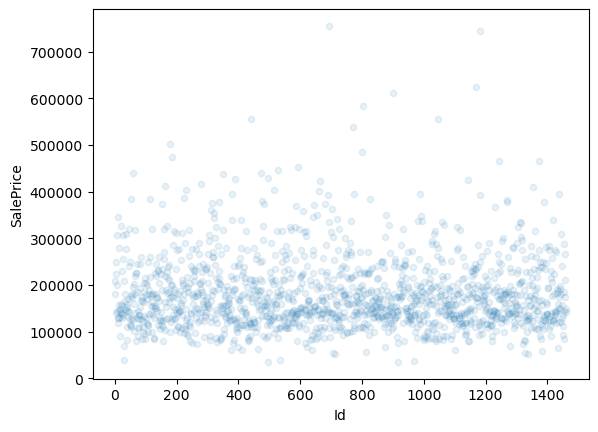

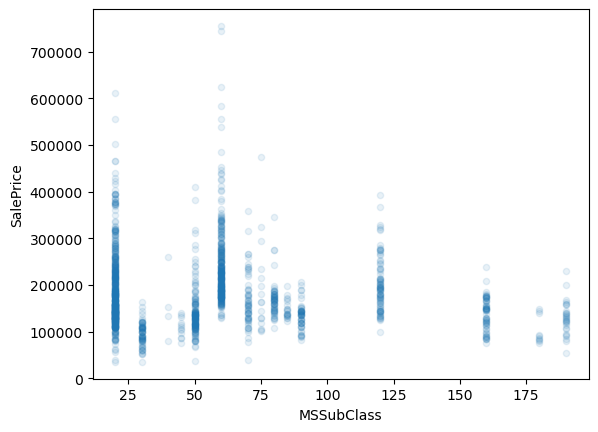

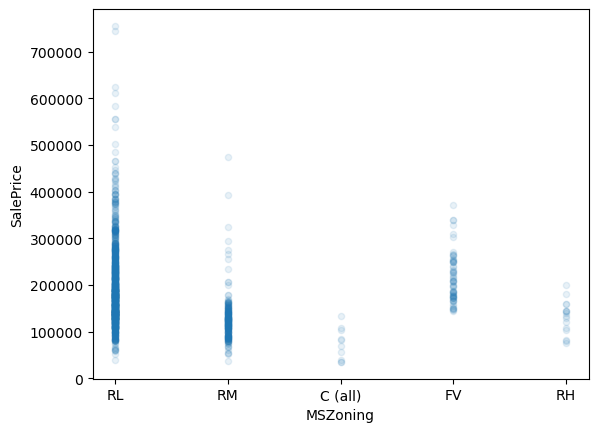

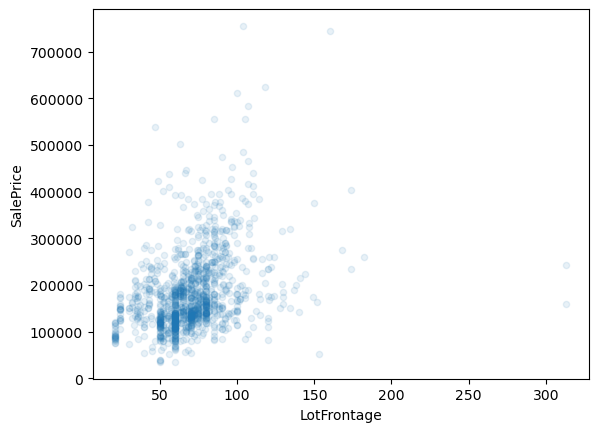

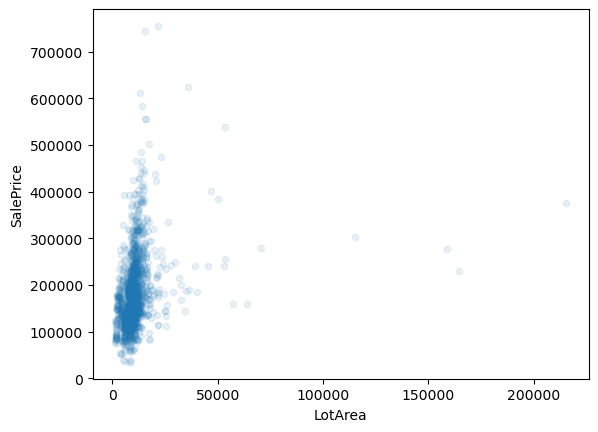

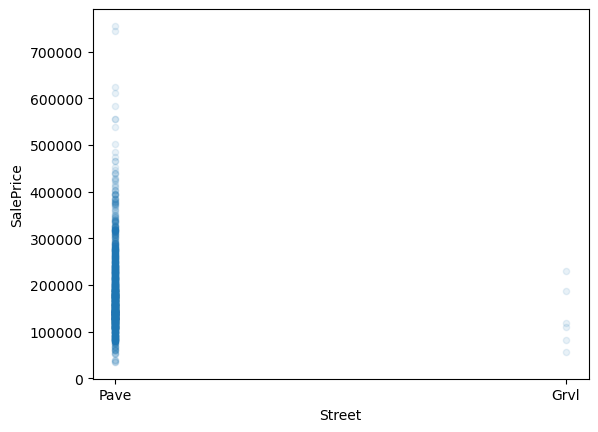

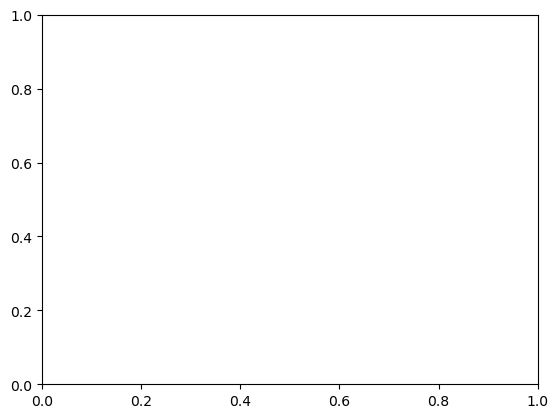

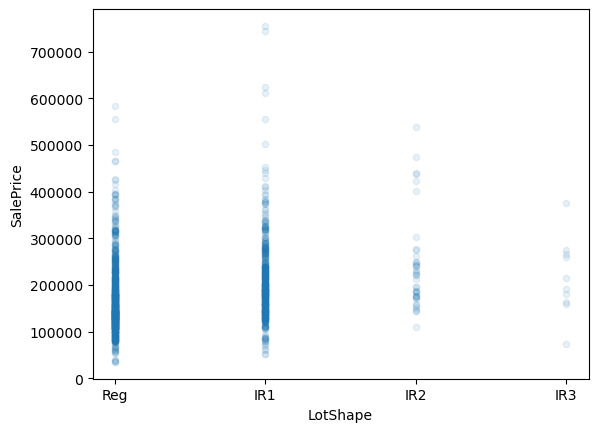

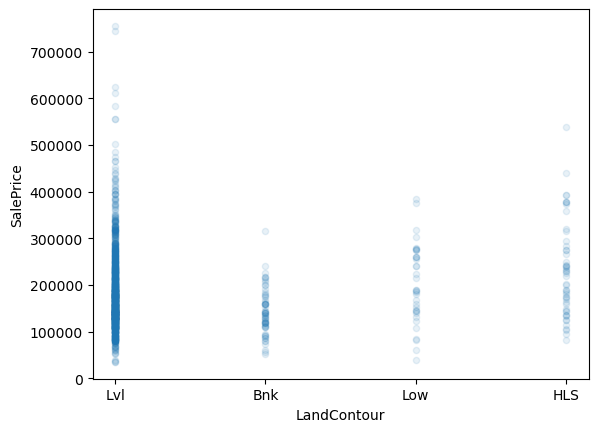

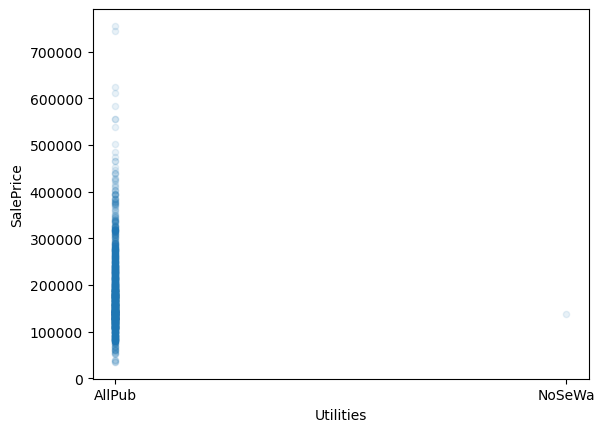

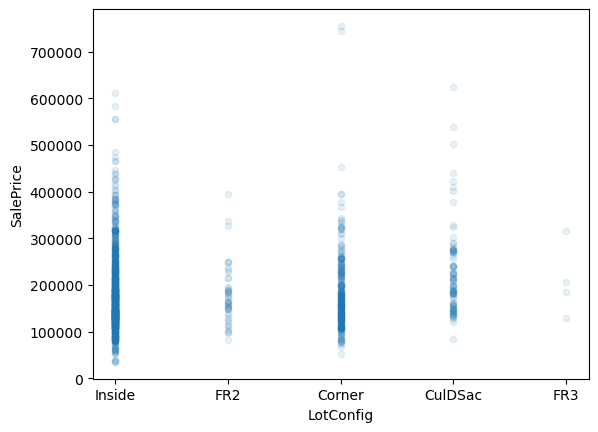

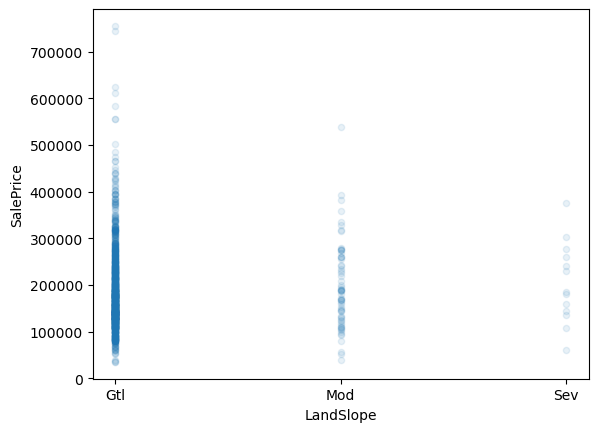

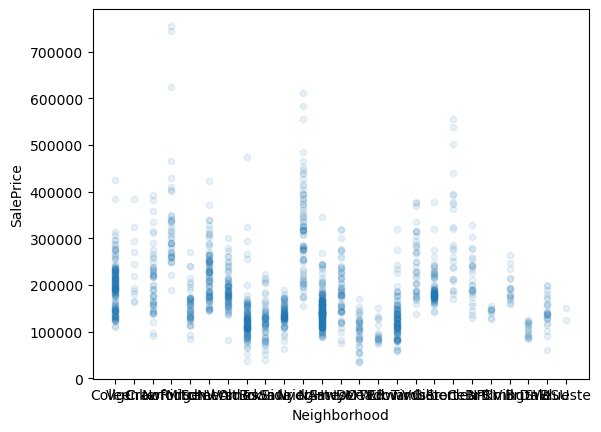

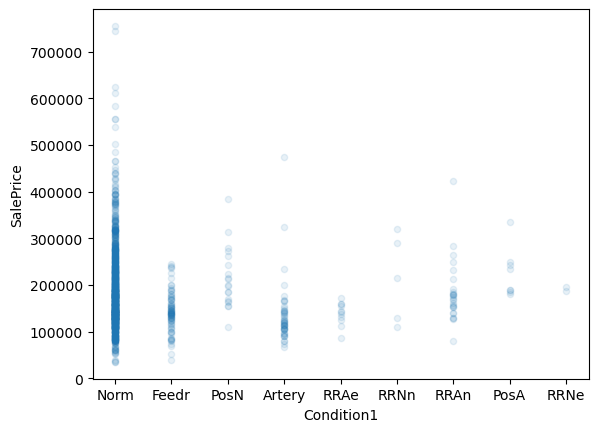

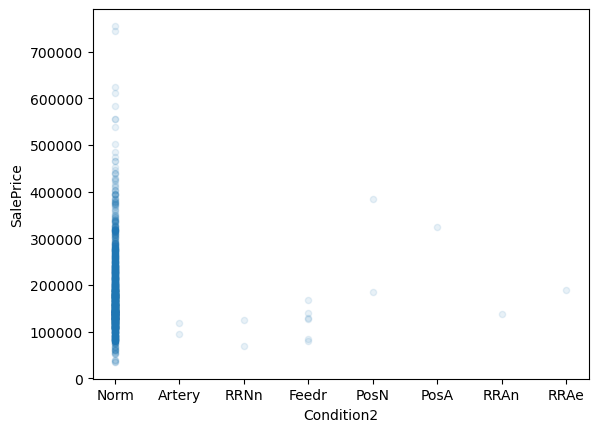

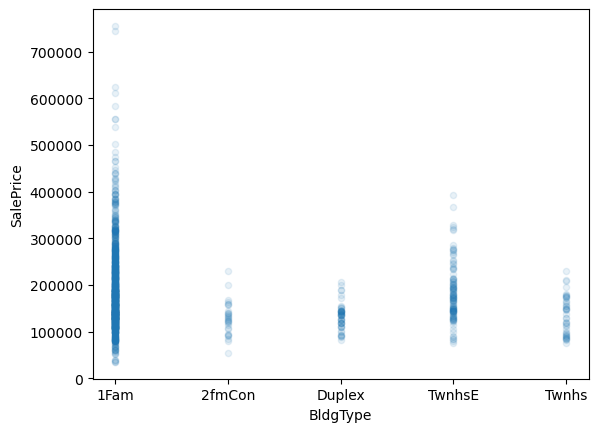

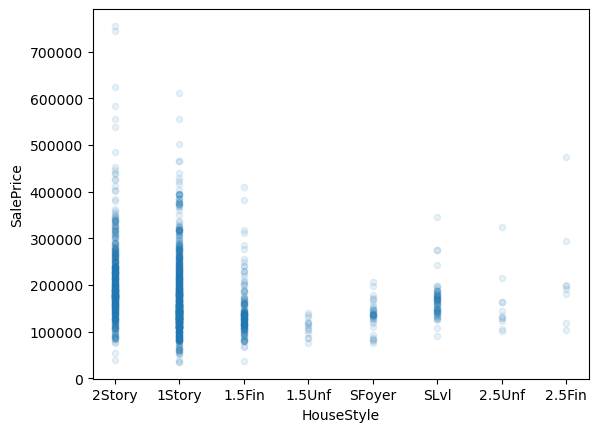

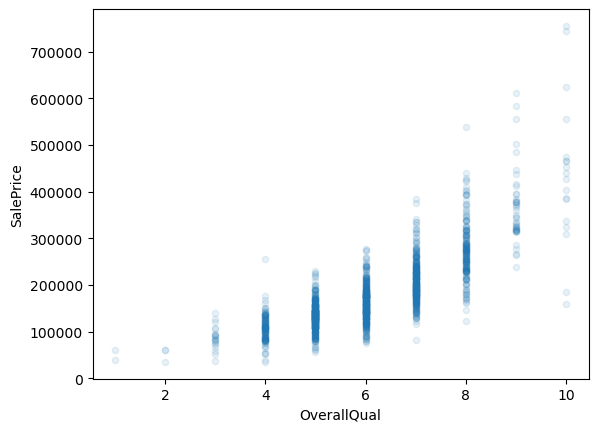

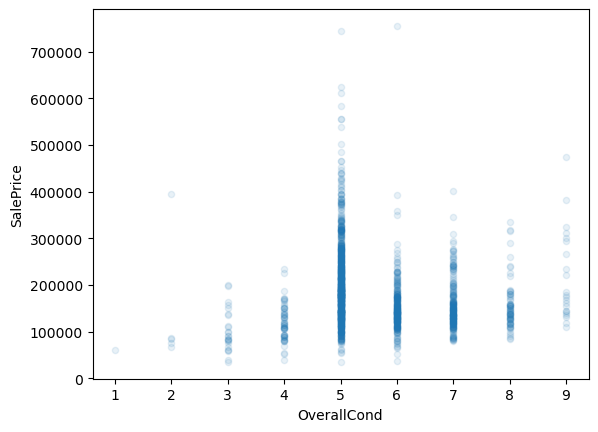

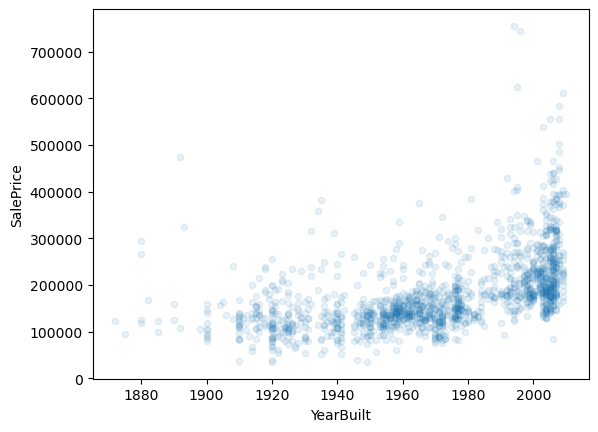

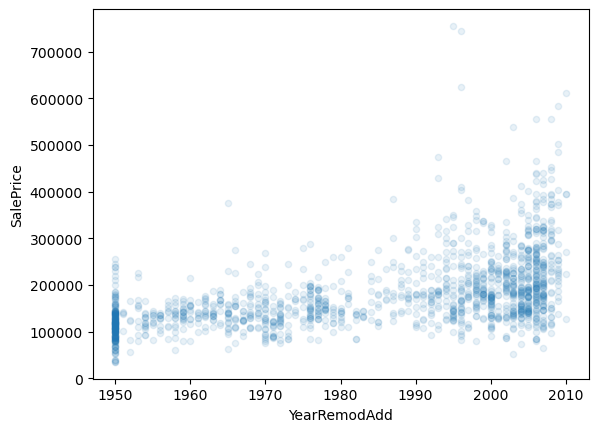

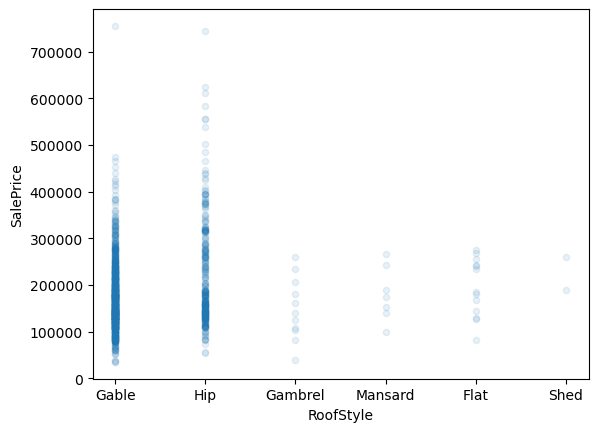

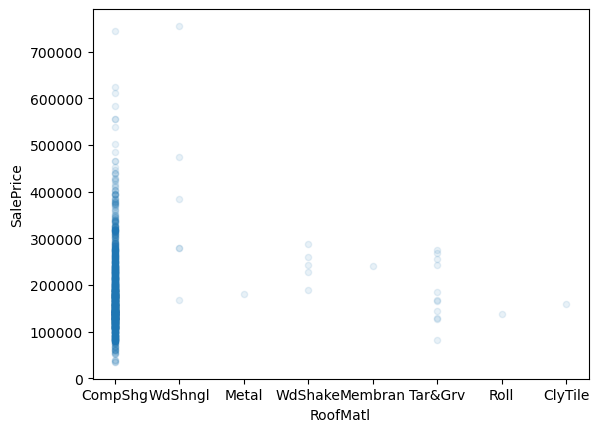

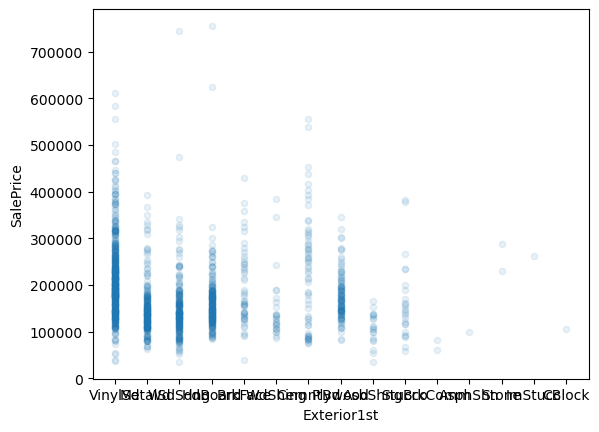

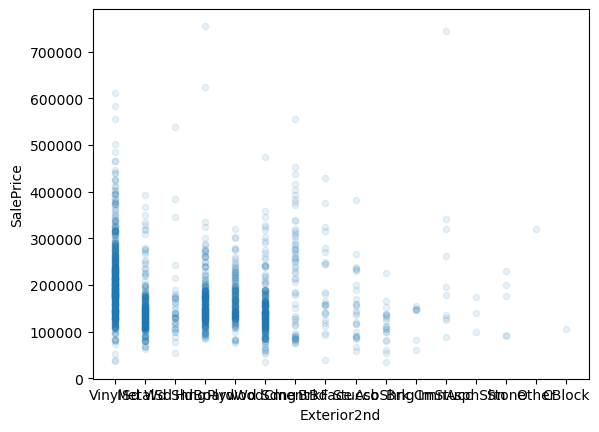

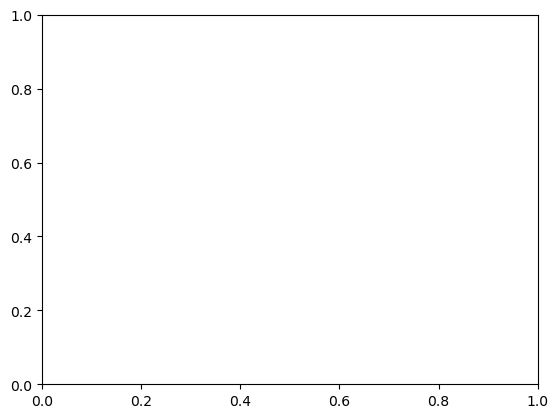

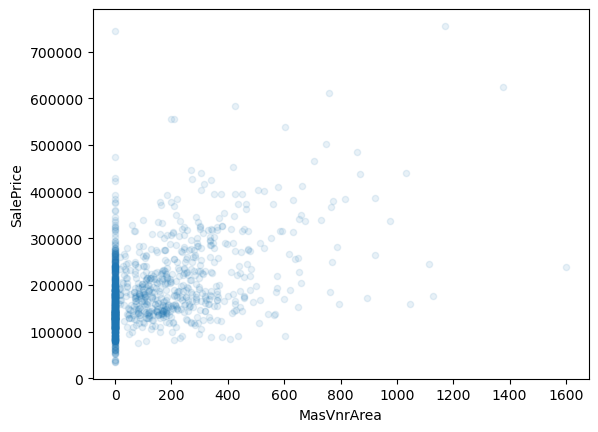

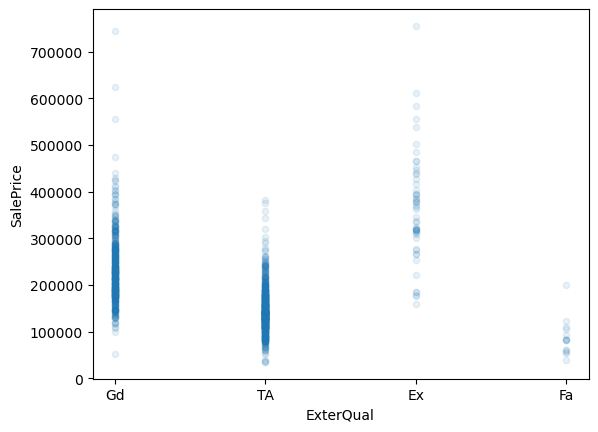

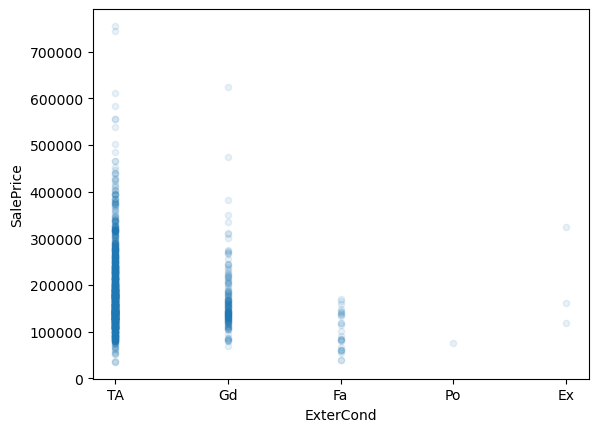

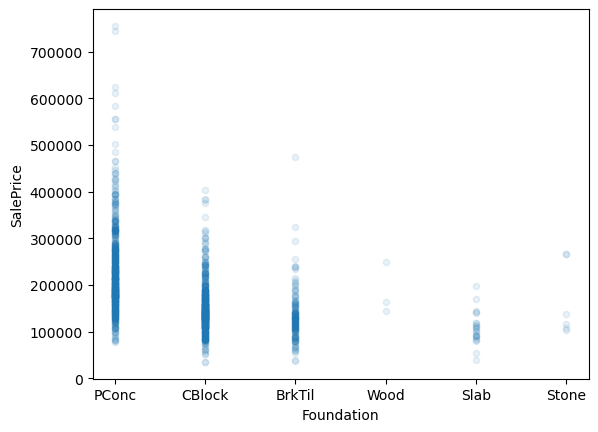

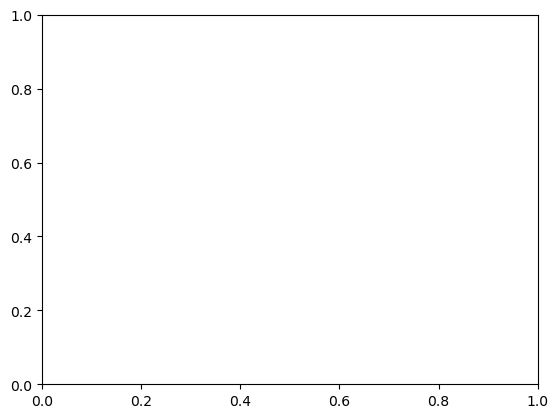

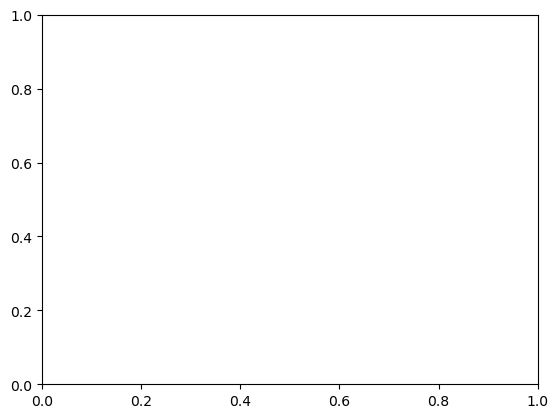

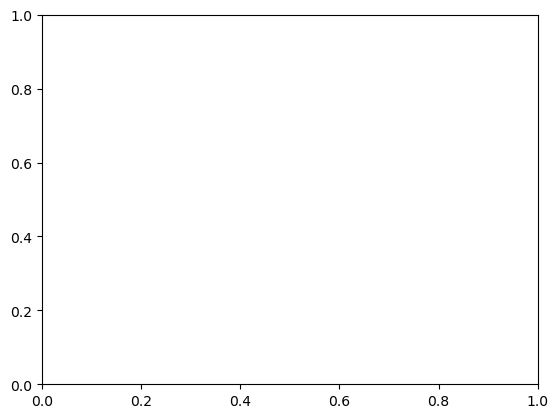

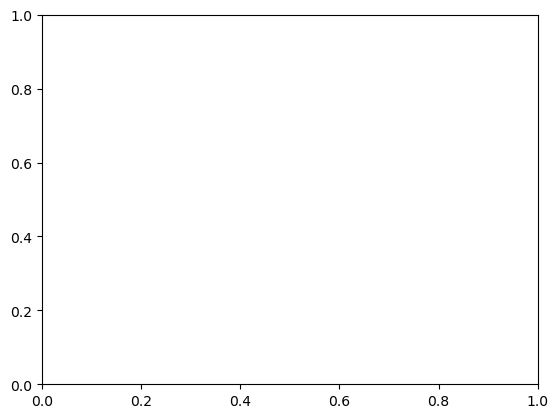

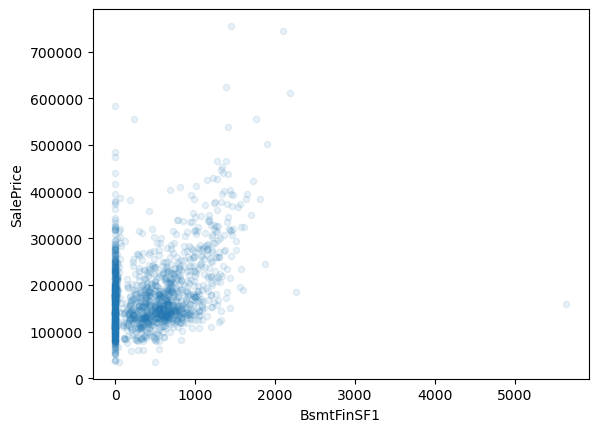

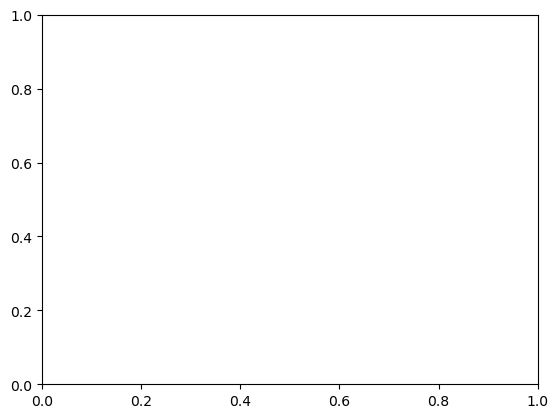

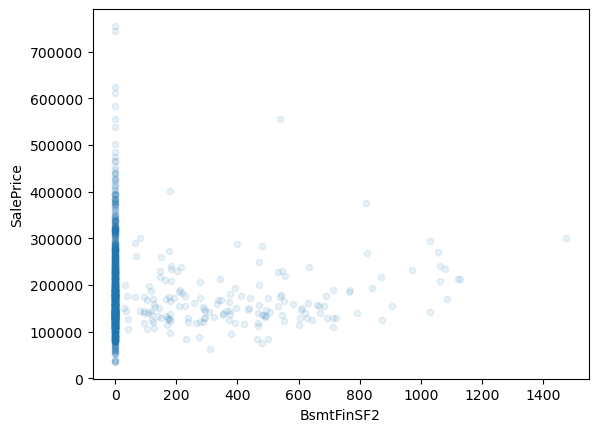

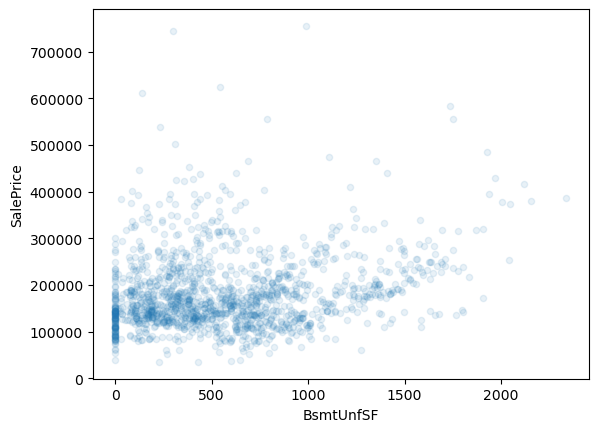

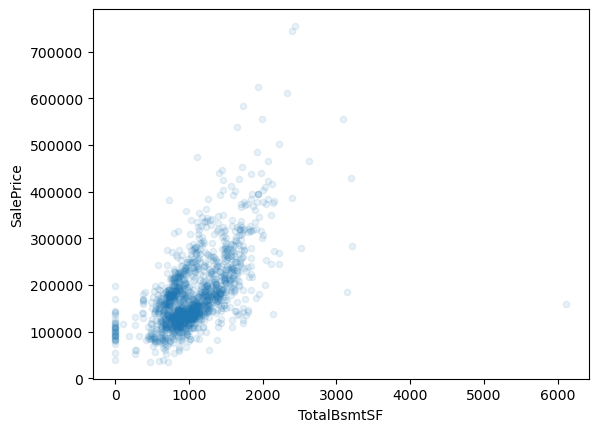

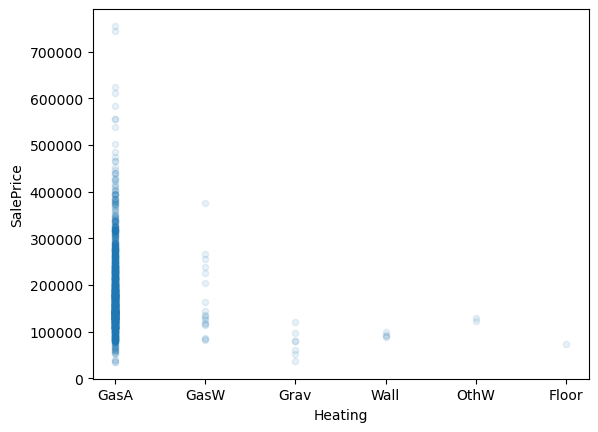

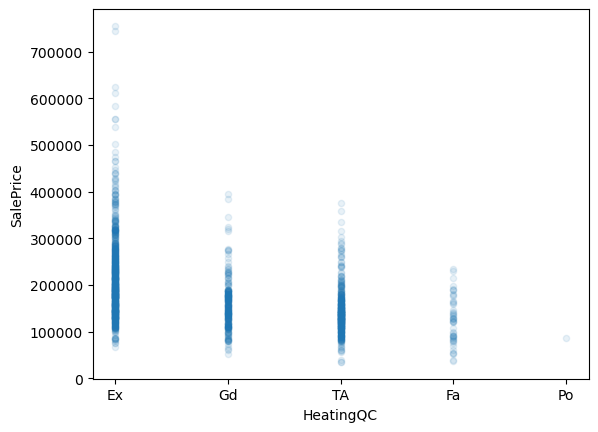

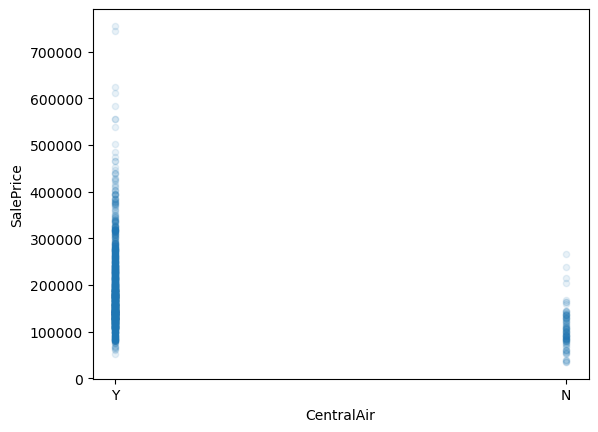

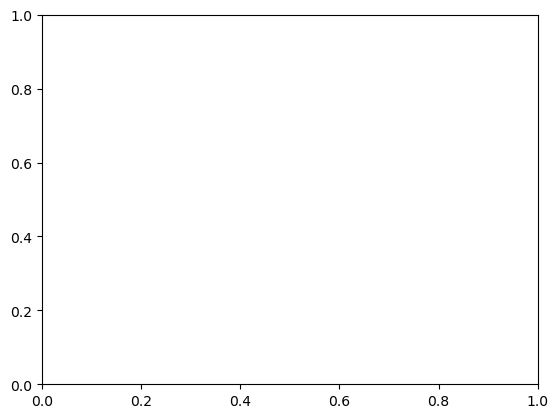

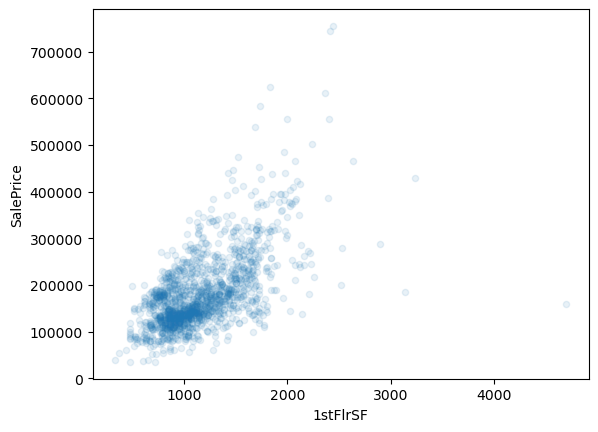

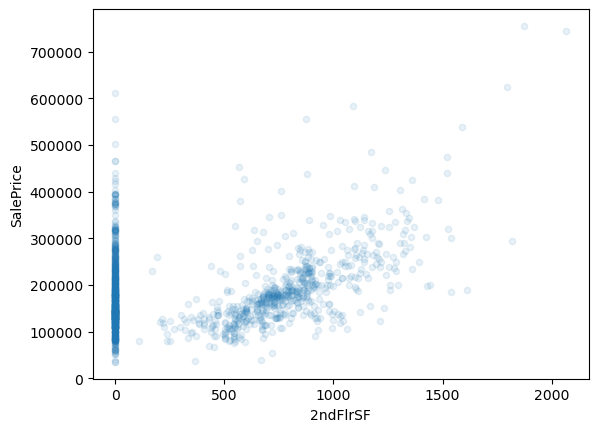

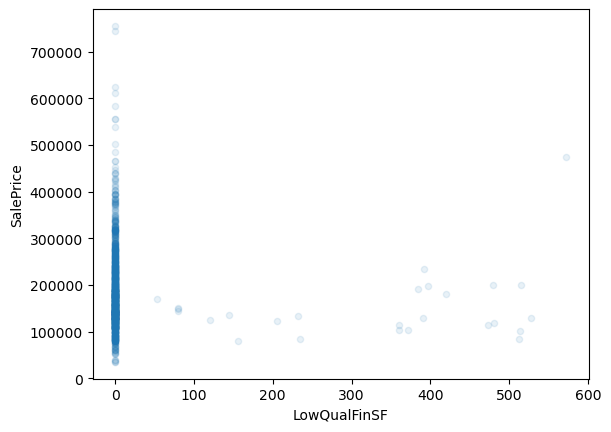

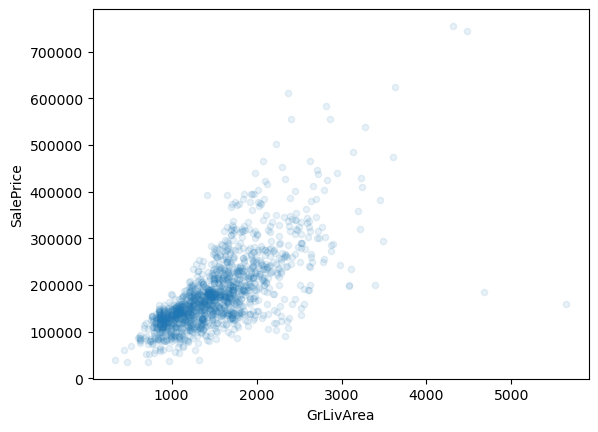

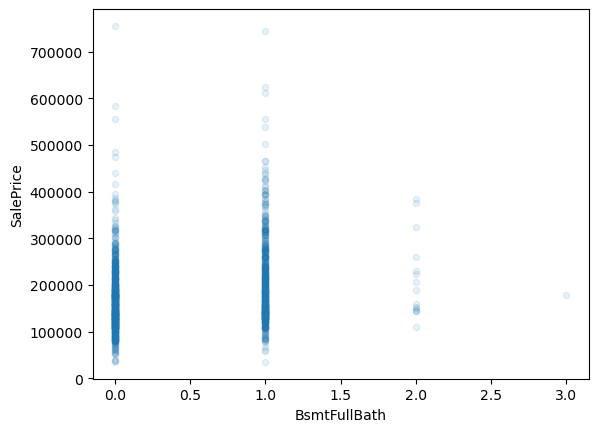

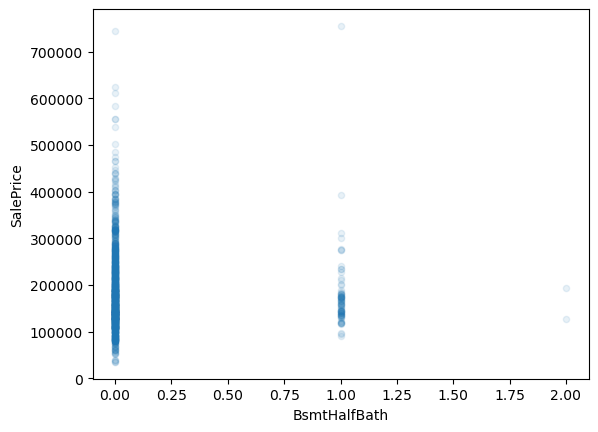

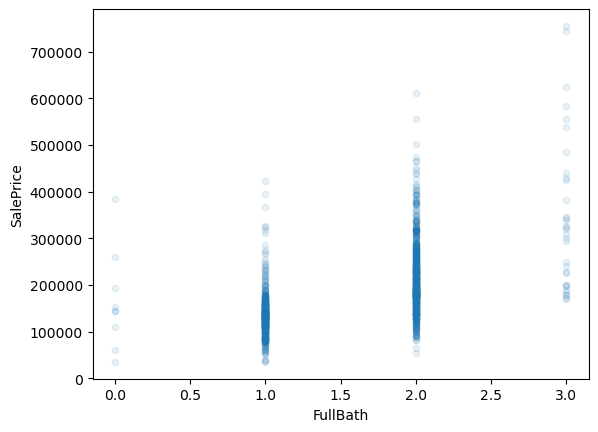

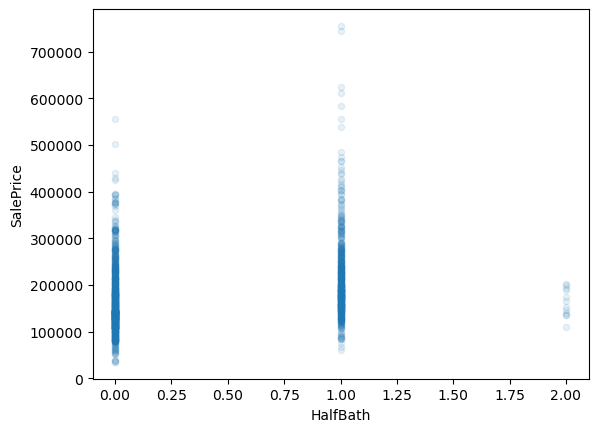

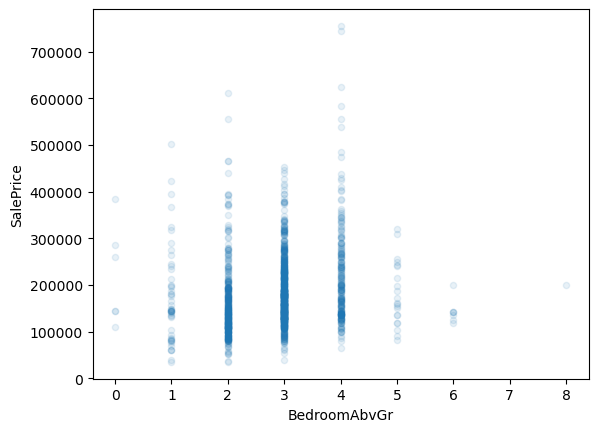

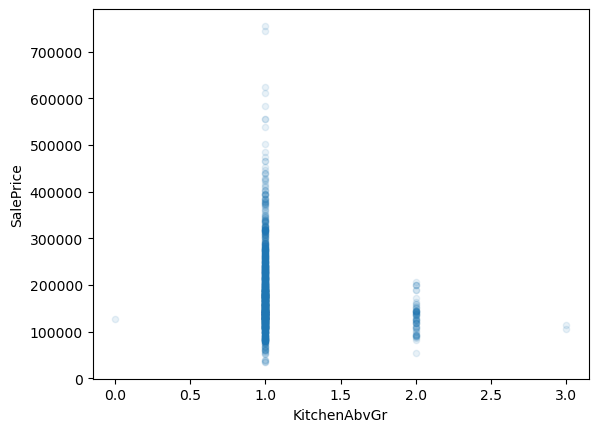

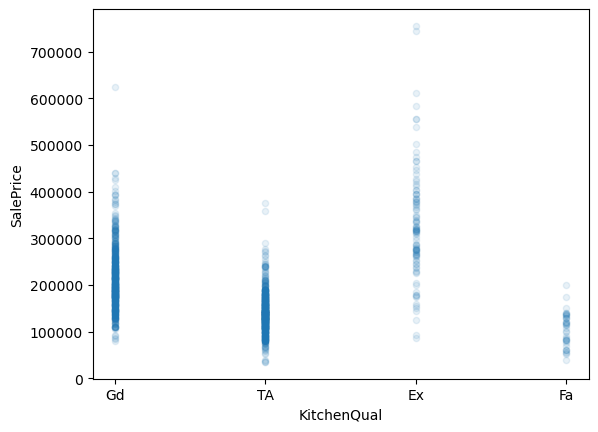

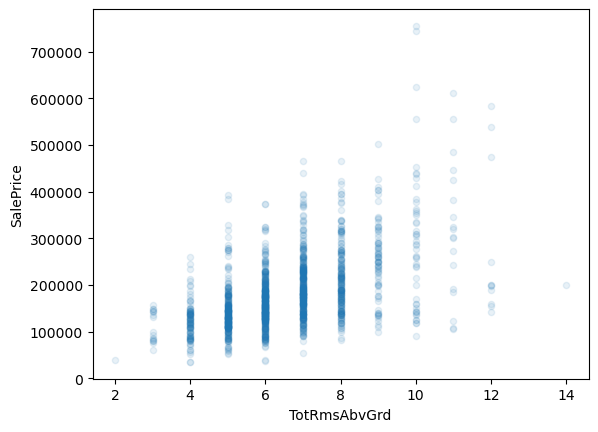

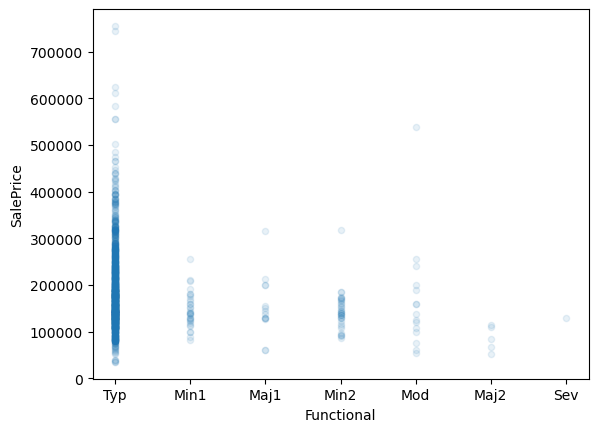

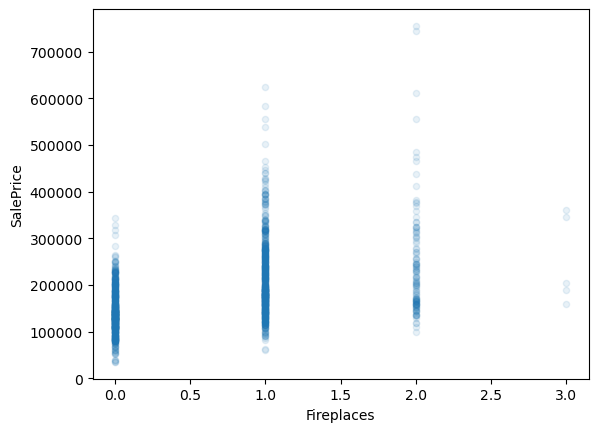

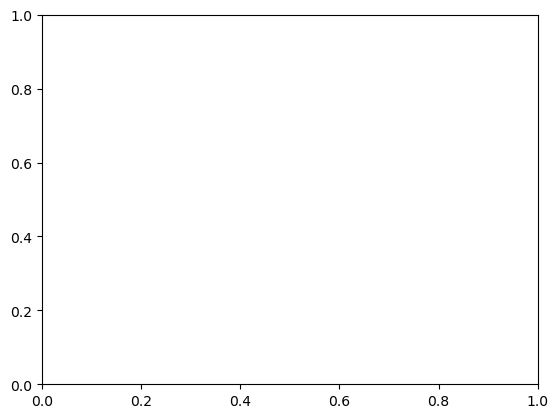

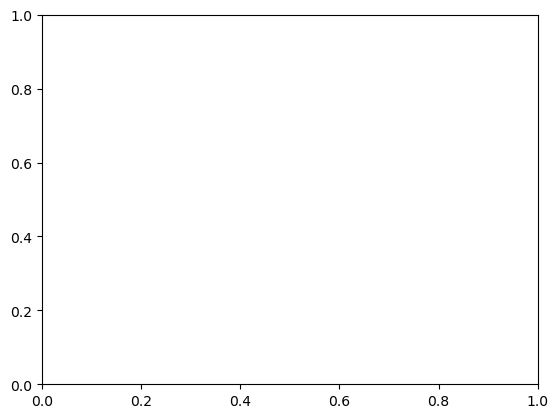

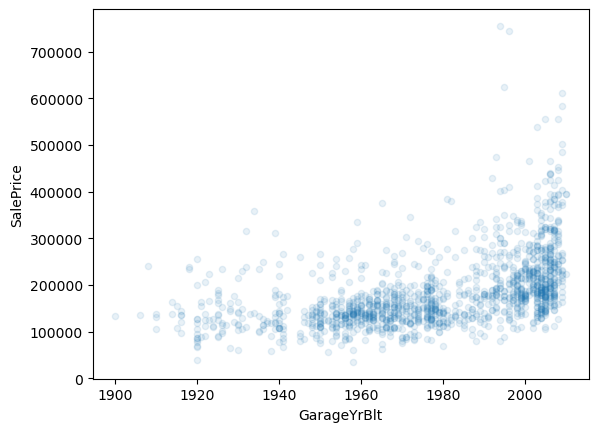

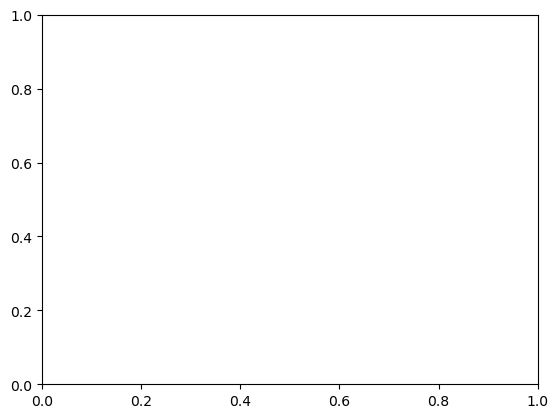

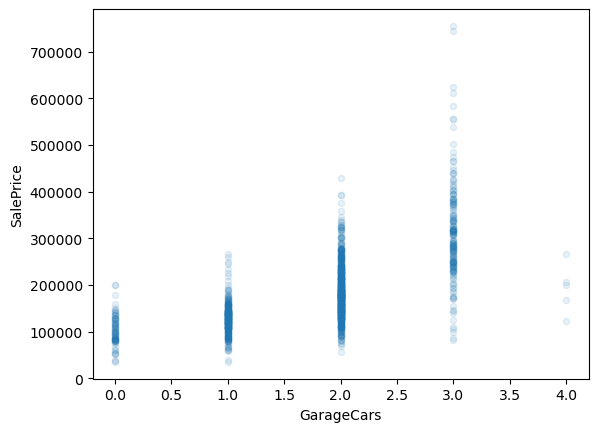

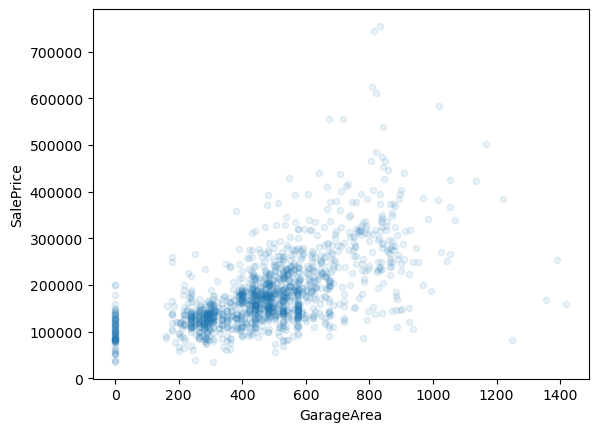

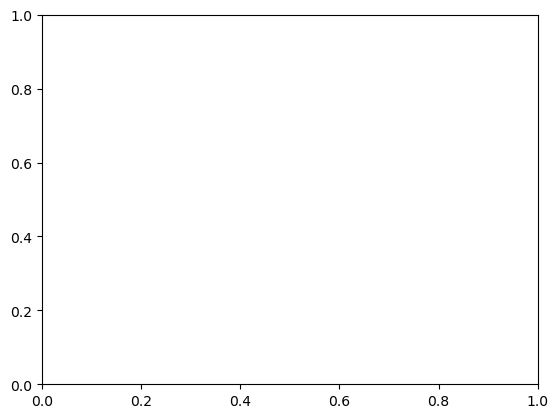

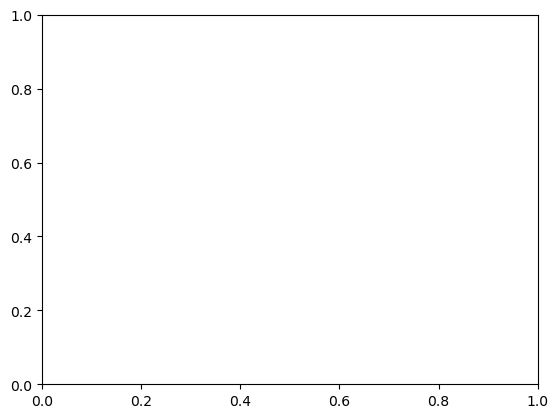

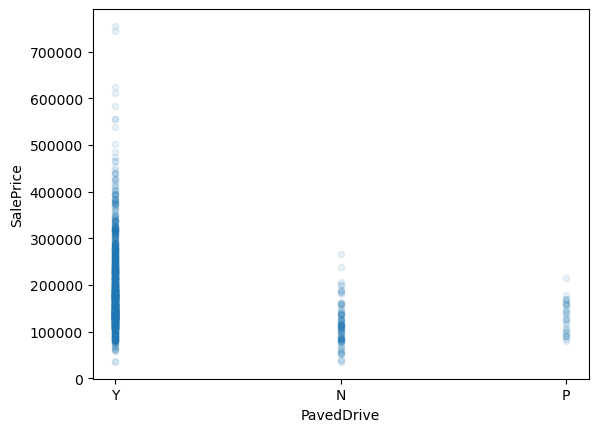

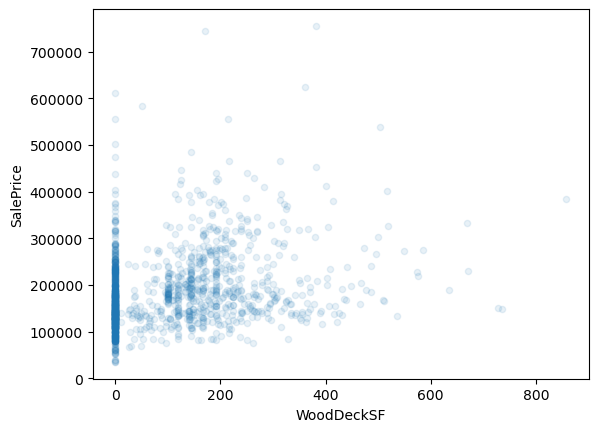

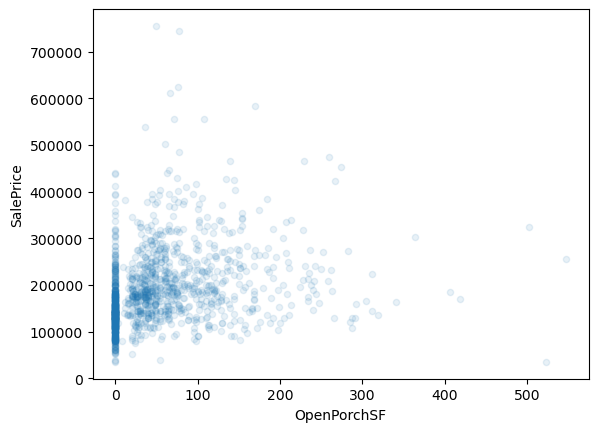

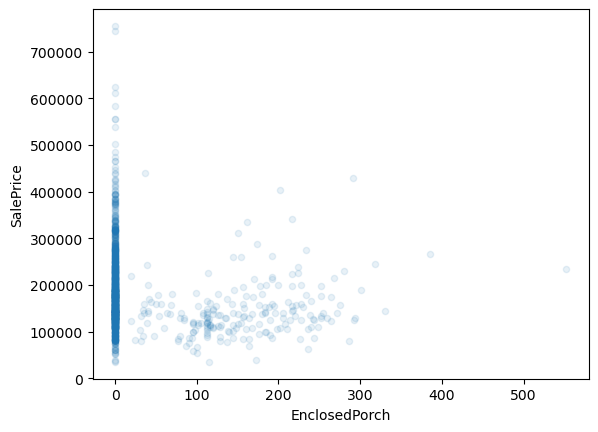

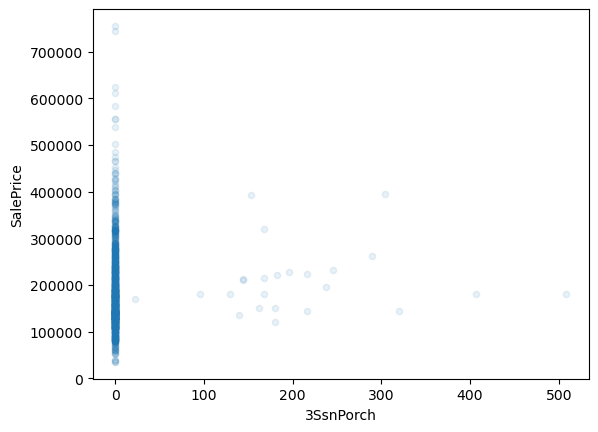

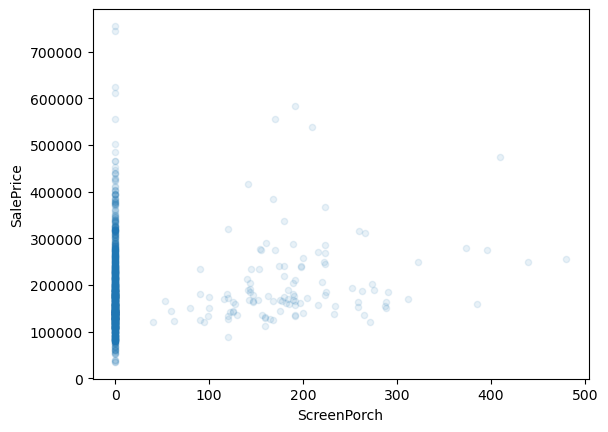

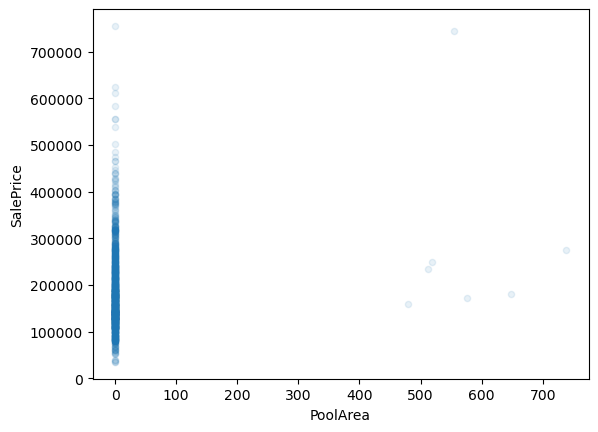

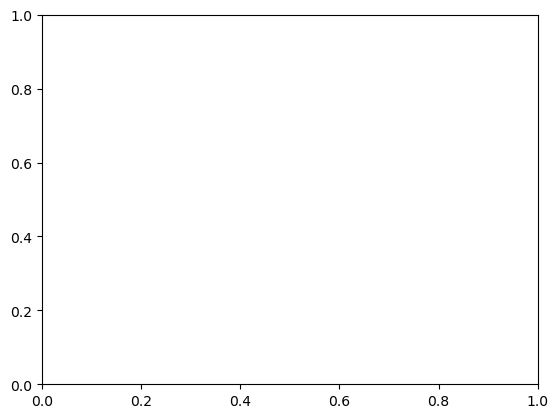

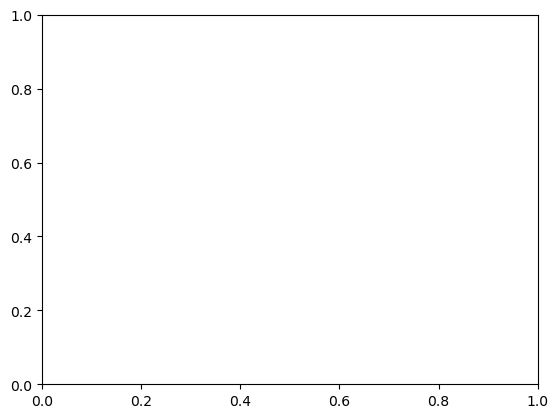

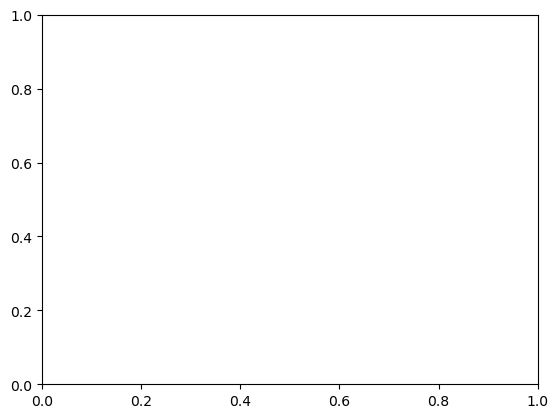

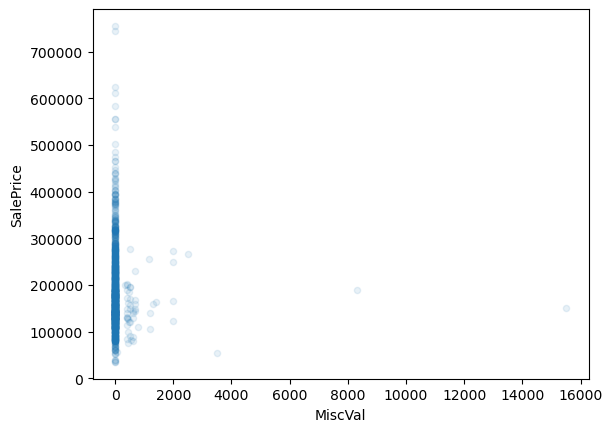

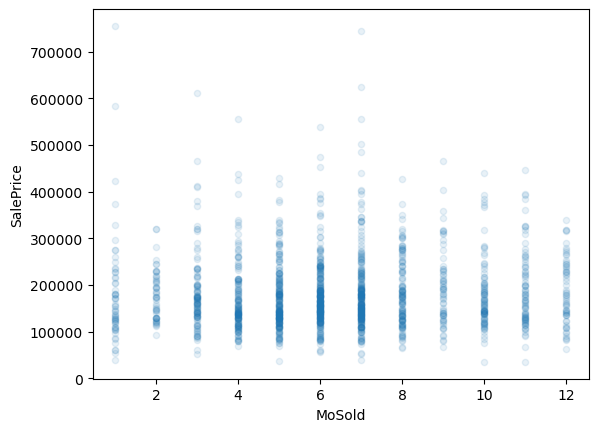

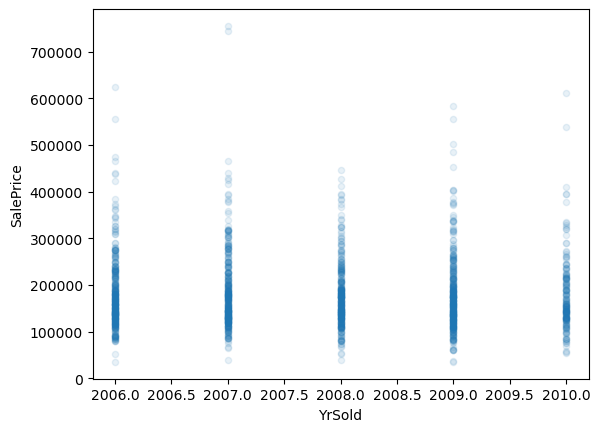

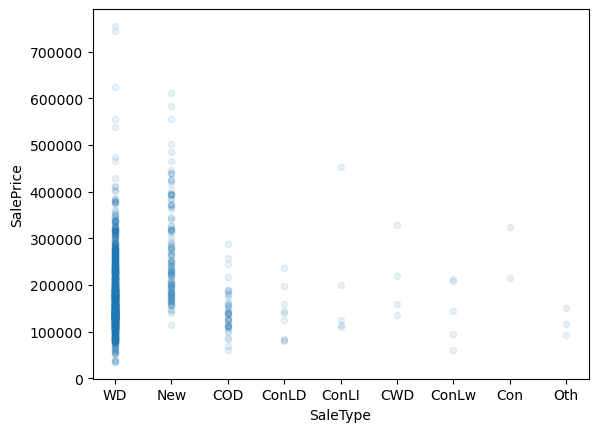

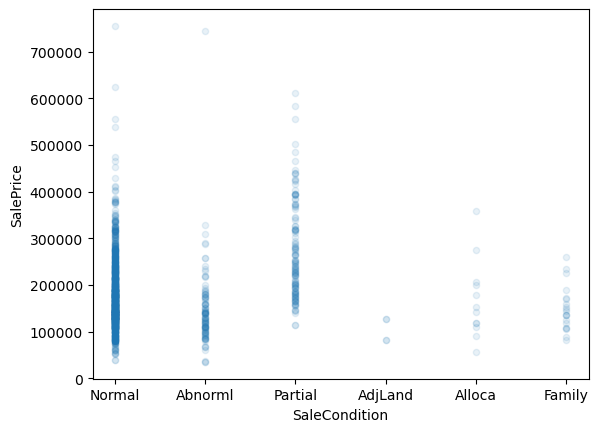

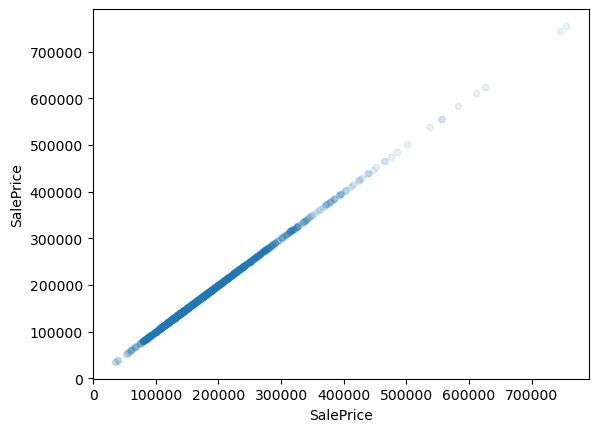

In [46]:
feats = train_set.columns
other_feats = []

for feat in feats:
    try:
        train_set.plot.scatter(x=feat, y='SalePrice', alpha=0.1)
    except:
        other_feats.append(feat)
            

In [47]:
print(other_feats)

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
train_set['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

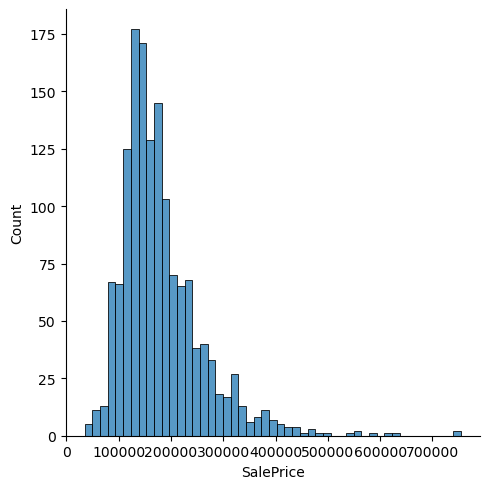

In [16]:
sns.displot(train_set['SalePrice'])

In [42]:
selected_features = [
    'MSSubClass', 'MSZoning', 'LandContour', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'OverallQual', 'OverallCond', 'YearRemodAdd',
    'ExterQual', 'ExterCond', 'Foundation', 'TotalBsmtSF',
    'HeatingQC', 'CentralAir', 'GrLivArea', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenQual', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
    'MiscVal', 'SaleCondition'
]

In [43]:
X = train_set[selected_features]
y = train_set['SalePrice']

## Data preprocessing

In [5]:
nan_vals_count = X.isnull().sum()
nan_vals_count.sum()

0

No NA values.

In [15]:
class SumColumns(BaseEstimator, TransformerMixin):
    def __init__(self, newcol=''):
        self.newcol = newcol
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.newcol] = X.sum(axis=1)
        return X

In [196]:
column_trans = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value=0), ['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']),
    (SimpleImputer(strategy='most_frequent'), ['MSZoning', 'KitchenQual']),
    (SumColumns('TotalArea'), ['GrLivArea', 'TotalBsmtSF']),
    (OneHotEncoder(handle_unknown='ignore', sparse=False), ['MSZoning', 'LandContour', 'Neighborhood',
                                                            'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                                            'Foundation', 'MiscVal', 'SaleCondition']),
    (OneHotEncoder(handle_unknown='ignore', sparse=False), ['MSSubClass']),
    (OrdinalEncoder(categories=[['Ex', 'Gd', 'TA', 'Fa', 'Po']]*4, handle_unknown='use_encoded_value', unknown_value=-1), ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['CentralAir']),
    remainder=StandardScaler()
)

In [178]:
test_set['MSSubClass'].unique()
X['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

In [205]:
tr = make_column_transformer(
    (SimpleImputer(strategy='most_frequent', copy=False), ['MSZoning', 'KitchenQual'])
)
Xt=SimpleImputer(strategy='most_frequent').fit_transform(X[['MSZoning', 'KitchenQual', 'TotalBsmtSF']])
#Xt=pd.DataFrame(tr.fit_transform(X[['MSZoning', 'KitchenQual']]))

In [206]:
Xt

array([['RL', 'Gd', 856],
       ['RL', 'TA', 1262],
       ['RL', 'Gd', 920],
       ...,
       ['RL', 'Gd', 1152],
       ['RL', 'Gd', 1078],
       ['RL', 'TA', 1256]], dtype=object)

## Models

### Decision Trees

In [179]:
test_set.loc[90:100,'KitchenQual']

90      TA
91      TA
92      Gd
93      TA
94      TA
95     NaN
96      TA
97      TA
98      TA
99      TA
100     TA
Name: KitchenQual, dtype: object

In [183]:
pipeline = Pipeline(steps=[
    ('transform', column_trans),
    ('tree', tree.DecisionTreeClassifier())
])

In [184]:
pipeline.fit(X, y)

ValueError: could not convert string to float: 'RL'

In [144]:
pipeline.score(X, y)

0.9924657534246575

In [150]:
pd.DataFrame(column_trans.transform(test_set).toarray())

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,896.0,882.0,1778.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.381743,-1.156380,-0.819964,-0.241061,-1.026041,-0.761621,-1.062465,-0.934130,-1.026858,1.202536
1,1329.0,1329.0,2658.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.381743,-1.301740,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.318683,-1.026858,-0.753188
2,1629.0,928.0,2557.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.517200,0.636400,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.318683,0.311725,0.042202
3,1604.0,926.0,2530.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.381743,0.636400,-0.819964,-0.241061,0.789741,1.227585,0.163779,0.296763,0.311725,-0.013943
4,1280.0,1280.0,2560.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.517200,0.345679,-0.819964,-0.241061,0.789741,-0.761621,-1.062465,-0.934130,0.311725,0.154492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1092.0,546.0,1638.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.280685,-0.720298,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.934130,-2.365440,-2.212963
1455,1092.0,546.0,1638.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.517200,-0.720298,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.318683,-1.026858,-0.874836
1456,1224.0,1224.0,2448.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.280685,0.539493,1.107810,-0.241061,-1.026041,-0.761621,1.390023,0.296763,0.311725,0.482006
1457,970.0,912.0,1882.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.517200,0.345679,-0.819964,3.948809,-1.026041,-0.761621,0.163779,-0.318683,-2.365440,-2.212963


In [146]:
pipeline.predict(test_set)

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values